In [8]:
#Imports
import sys,os
os.environ['MKL_NUM_THREADS'] = '4' # set number of MKL threads to run in parallel
from quspin.operators import hamiltonian,quantum_operator
from quspin.basis import spin_basis_1d
from numpy.random import uniform,seed
from joblib import delayed,Parallel
from itertools import combinations
from functools import partial
import numpy as np
import gc
import pickle
from time import time
from quspin.tools.measurements import diag_ensemble
from quspin.tools.evolution import ED_state_vs_time
import matplotlib.pyplot as plt
from quspin.tools.lanczos import lanczos_full, expm_lanczos
timestamp = time()

In [ ]:
###Functions
def timer(timestamp):
    #Timer Function
    print("time =", time()-timestamp)
    return

def fin_string(ns,s): #ns = length of string s = operator
    #Max string length
    if ns>L:
        ns=L
    else:
        pass
    
    
    def linears(start,m):
        #Find all indices in string
        ind=[i%L for i in range(start,start+ns)]
     #All combinations
        perm=list(combinations(ind,m))
      #Add each coupling to operator
        for j in range(len(perm)):
#            S_temp=[((-1)**m)*(2**m)/(L*(2**ns))] ########### Down #
            S_temp=[1/(L*(2**ns))] ###################### Up
            for i in range(len(perm[j])):
                S_temp.append(perm[j][i])
        ##Saving Couplin gs lists
            if j==0: 
                S_temp_2=[S_temp]
            else: 
                S_temp_2.append(S_temp)
        return S_temp_2
    #List to store orders of interaction
    o_type=np.empty(ns,dtype=object)
    
    for i in range(ns):
        #ex: "z"*2= "zz"
        o_type[i]=s*(i+1)

    #Iterate over each Site
    for k in range(L):
        #Iterate over different string lengths
      for i in range(ns):
          #First item defines list
          if k==0 and i==0:
              #example: i = 0 operator_list = [['x', linears(k,1)]]
              operator_list=[[o_type[i],linears(k,i+1)]]
          else:
              operator_list.append([o_type[i],linears(k,i+1)])
    S_temp_1 = [[(1/((ns*2**ns))), i] for i in range(ns)]
    #S_temp_1 = [[(1/((ns*2**(ns)))), 1] ]
    operator_list.append(["I",S_temp_1])
    operator_dict=dict(S=operator_list)
    O = quantum_operator(operator_dict,basis=basis,check_symm=False,check_herm=False)
    return O, operator_list




def adiabatic_lanczos_evolution(H, h0, hf, tau, steps=200, krylov_dim=15):
    """
    Perform adiabatic time evolution using Lanczos approximation.

    Parameters:
        H           : quspin operator_dict Hamiltonian object
        h0          : initial field value
        hf          : final field value
        tau         : total evolution time
        steps       : number of time steps
        krylov_dim  : dimension of Krylov subspace

    Returns:
        v_t_list    : list of evolved states at each time
        V0          : initial ground state
        Vf[:,0]     : final ground state
        times       : array of time values
        h_vals      : array of h(t) values
    """
    # initial Hamiltonian and ground state
    H0 = H.tohamiltonian(dict(H0=1, Quench=h0))
    E0, V0_full = np.linalg.eigh(H0.todense())
    V0 = np.array(V0_full)[:, 0]
    # time grid
    times = np.linspace(0, tau, steps)
    dt = times[1] - times[0]
    h_vals = h0 + (hf - h0) * (times / tau)

    # time evolution
    v_t = V0.copy()
    v_t_list = [v_t.copy()]
    for t, h_val in zip(times[1:], h_vals[1:]):
        Ht = H.tohamiltonian(dict(H0=1, Quench=h_val))
        El, Vl, Q = lanczos_full(Ht, v_t, krylov_dim)
        v_t = expm_lanczos(El, Vl, Q, -1j * dt)
        v_t_list.append(v_t.copy())

    # final ground state
    Hf = H.tohamiltonian(dict(H0=1, Quench=hf))
    Ef, Vf = np.linalg.eigh(Hf.todense())
    Vf = np.array(Vf)

    return v_t_list, times, h_vals, V0, Vf


In [161]:
###### Model parameters

#Length of chain
L = 12
#X fields
J1 = 1 #NN term 
J2 = 0 #NNN Term
#Initial z field strength
h0 = 0
#Final z fields
h_i,dh = np.linspace(0,2,100,retstep=True)
#Basis being projected
op = "x"

In [162]:
###Using Quantum_Operator to build hamitlonian 
timestamp = time()
basis = spin_basis_1d(L, pauli = -1, pblock= 1,kblock=0)


#NN Sigma x term (Periodic Boundary Conditions)
NN_sigma_x = [ [-J1, i, (i+1)%L] for i in range(L)]
#NNN Sigma x term (PBC)
NNN_sigma_x = [ [-J2,i, (i+2)%L] for i in range(L)]
#site coupling lists
sigma_z = [ [1, i] for i in range(L)]
#Define the static H (that doesn't change)
static_H = [ ["xx", NN_sigma_x], ["xx", NNN_sigma_x] ] 
#The z field is the quench
Quenching_H = [["z", sigma_z]]
#Define operator dictionary
operator_dict = dict(H0= static_H, Quench = Quenching_H)
#Build Hamiltonian
H = quantum_operator(operator_dict, basis=basis, check_herm= False, check_symm = False);
#Build Projectors
Projectors = [fin_string(i,op)[0] for i in range(1,L+1)]
timer(timestamp)

time = 24.171831846237183


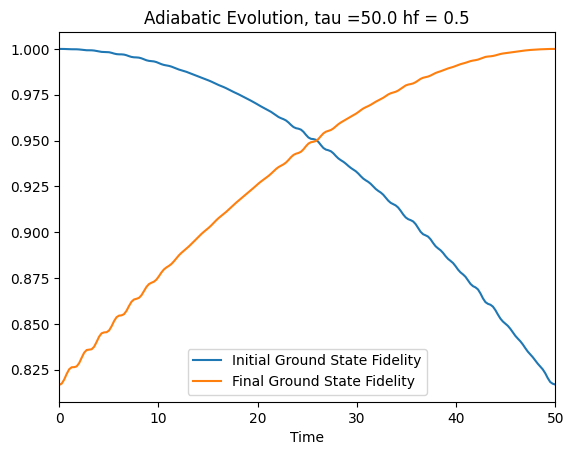

In [163]:
 vt, times, h_vals, V0, Vf = adiabatic_lanczos_evolution(H, 0, 0.5, 50, steps=200, krylov_dim=15)

plt.plot(times,[np.abs(V0@vt[i])**2 for i in range(len(vt))],label="Initial Ground State Fidelity")
plt.plot(times,[np.abs(Vf[:,0]@vt[i])**2 for i in range(len(vt))],label="Final Ground State Fidelity")
plt.xlim(times[0],times[-1])
plt.title("Adiabatic Evolution, tau =" + str(times[-1]) + " hf = " + str(h_vals[-1]))
plt.xlabel("Time")
plt.legend()

In [164]:
h0 = 0
taus = np.array([0.1,1,10,100])
step_density = 100
steps = taus*step_density
D_krylov = 15
final_v_tau = []

##WTF is this name?!? Should just be final groundstates as a function of h, tau
final_ex_v_tau =[]
timestamp = time()
for j in range(len(taus)):
    final_v = []
    final_ex_v = []
    for hf in h_i:

        vt, times, h_vals, V0, Vf = adiabatic_lanczos_evolution(H, h0, hf, taus[j], steps=int(steps[j]), krylov_dim=D_krylov)
        final_v.append(vt[-1])
        final_ex_v.append(Vf)
        if hf == h_i[len(h_i)//2]:
            print(f"tau = {taus[j]}")
            timer(timestamp)
    final_v_tau.append(final_v)
    final_ex_v_tau.append(final_ex_v)
    timer(timestamp)



tau = 0.1
time = 2.0570900440216064
time = 3.869025230407715
tau = 1.0
time = 13.537896156311035
time = 22.80302405357361
tau = 10.0
time = 92.33162808418274
time = 157.33614110946655
tau = 100.0
time = 824.9053552150726
time = 1511.4136369228363


In [171]:
len(V0)

224

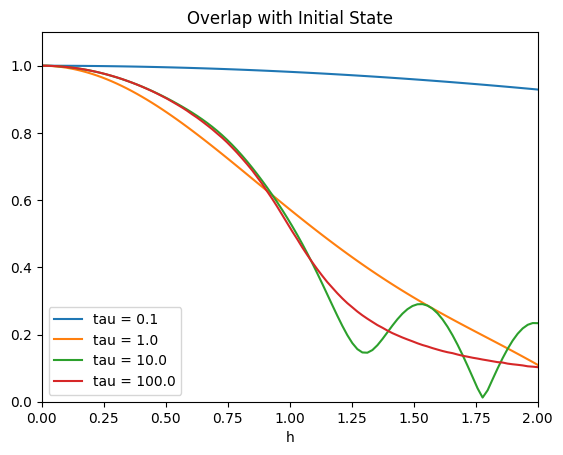

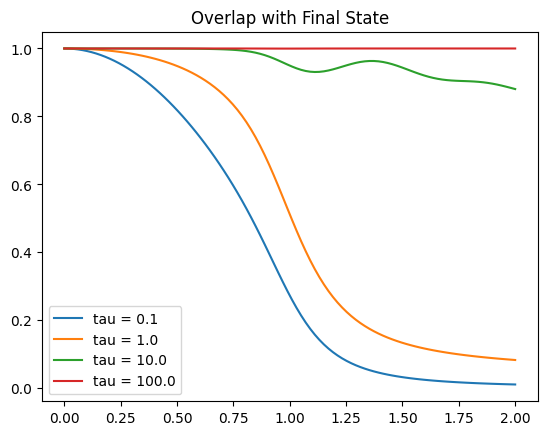

In [172]:
plt.figure()
for j in range(4):
    test = [np.abs(V0@final_v_tau[j][i]) for i in range(len(final_v))]
    plt.title("Overlap with Initial State")
    plt.plot(h_i,test,label = f"tau = {taus[j]}")
    plt.xlabel("h")
    plt.ylim(0,1.1)
    plt.xlim(0,2)
    plt.legend()

plt.figure()

for j in range(4):
    test = [np.abs(final_ex_v_tau[j][i][:,0]@final_v_tau[j][i])**2 for i in range(len(final_v))]
    plt.title("Overlap with Final State")
    plt.plot(h_i,test,label = f"tau = {taus[j]}")
    plt.legend()

/opt/anaconda3/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


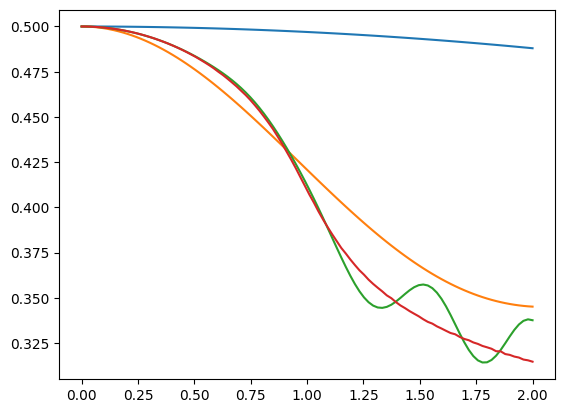

In [173]:
for j in range(4):
    dat_test = [Projectors[1].expt_value(final_v_tau[j][i]) for i in range(len(final_v))]
    plt.plot(h_i,dat_test)

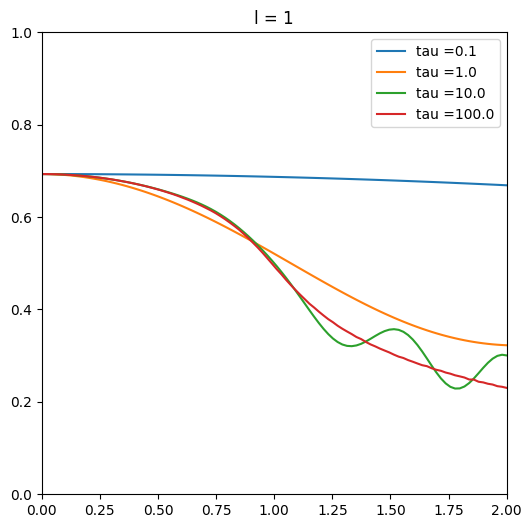

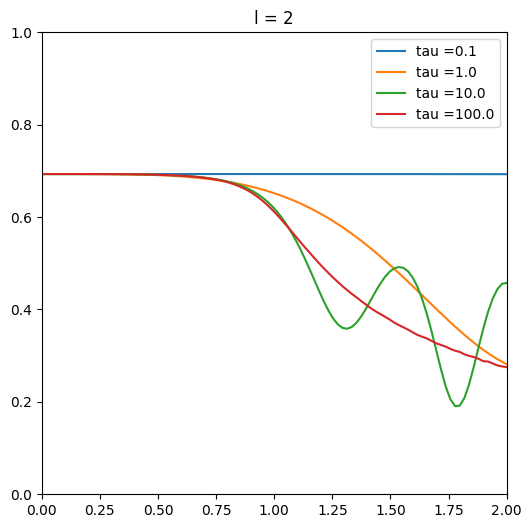

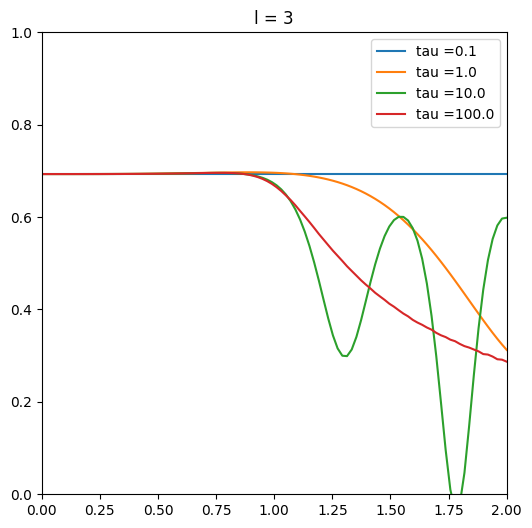

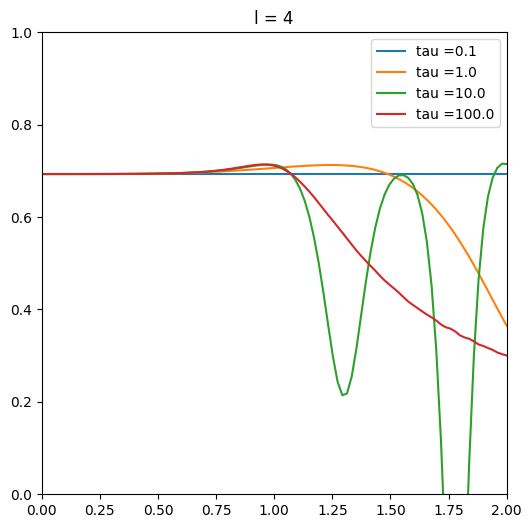

In [174]:
mut_info_coords = [[1,0],[3,1],[5,2],[7,3]]
for c in mut_info_coords:
    x,y = c
    plt.figure(figsize=(6,6))
    for j in range(4):
        plt.title(f"l = {y+1}")
     
        numerator = np.array([Projectors[x].expt_value(final_v_tau[j][i]) for i in range(len(final_v))])
        denominator=np.array([Projectors[y].expt_value(final_v_tau[j][i]) for i in range(len(final_v))])

        dat_test = np.log(numerator/denominator**2)
        plt.plot(h_i,dat_test,label = f"tau ={taus[j]}")
        plt.xlim(h_i[0],h_i[-1])
        plt.ylim(0,1)
        plt.legend()